HW 9 Lecture 10

Apply classification metrics to MNIST classification problem 
- Accuracy (per class and general)
- Precision (per class and general)
- Recall (per class and general)
- F1-score (per class and general)
- Confusion matrix
- Classification report

In [8]:
"""
Dataset references:
http://pjreddie.com/media/files/mnist_train.csv
http://pjreddie.com/media/files/mnist_test.csv
"""

from pathlib import Path
from typing import Tuple
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(1337)

class MnistMlp(torch.nn.Module):
    
    def __init__(self, inputnodes: int, hiddennodes: int, outputnodes: int) -> None:
        super().__init__()

        # number of nodes (neurons) in input, hidden, and output layer
        self.wih = torch.nn.Linear(in_features=inputnodes, out_features=hiddennodes)
        self.who = torch.nn.Linear(in_features=hiddennodes, out_features=outputnodes)
        self.activation = torch.nn.Sigmoid()

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.wih(x)
        out = self.activation(out)
        out = self.who(out)
        return out


class MnistDataset(Dataset):
    
    def __init__(self, filepath: Path) -> None:
        super().__init__()

        self.data_list = None
        with open(filepath, "r") as f:
            self.data_list = f.readlines()

        # conver string data to torch Tensor data type
        self.features = []
        self.targets = []
        for record in self.data_list:
            all_values = record.split(",")
            features = np.asfarray(all_values[1:])
            target = int(all_values[0])
            self.features.append(features)
            self.targets.append(target)

        self.features = torch.tensor(np.array(self.features), dtype=torch.float) / 255.0
        self.targets = torch.tensor(np.array(self.targets), dtype=torch.long)
        # print(self.features.shape)
        # print(self.targets.shape)
        # print(self.features.max(), self.features.min())

    
    def __len__(self) -> int:
        return len(self.features)
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.features[index], self.targets[index]


if __name__ == "__main__":
    # Device for training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize empty lists to store training and test losses during training
    training_losses = []
    test_losses = []

    # NN architecture:
    # number of input, hidden and output nodes
    input_nodes = 784
    hidden_nodes = 200
    output_nodes = 10

    # learning rate is 0.1
    learning_rate = 0.1
    # batch size
    batch_size = 10
    # number of epochs
    epochs = 10

    # Load mnist training and testing data CSV file into a datasets
    train_dataset = MnistDataset(filepath="./mnist_train.csv")
    test_dataset = MnistDataset(filepath="./mnist_test.csv")

    # Make data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    # Define NN
    model = MnistMlp(inputnodes=input_nodes, 
                     hiddennodes=hidden_nodes, 
                     outputnodes=output_nodes)
    # Number of parameters in the model
    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    model = model.to(device=device)
    
    # Define Loss
    criterion = torch.nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Initialize variables for metrics
    true_labels = []
    predicted_labels = []

    ##### Training! #####
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        test_loss = 0.0
        correct = 0

        for batch_idx, (features, target) in enumerate(train_loader):
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(features), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            
            # Accumulate the running loss
            running_loss += loss.item()
    
        # Calculate the average training loss for the epoch
        average_train_loss = running_loss / len(train_loader)
        training_losses.append(average_train_loss)
        ##### Testing! #####
        model.eval()
        with torch.inference_mode():
            for features, target in test_loader:
                features, target = features.to(device), target.to(device)
                output = model(features)
                test_loss += criterion(output, target).item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                # Collect true and predicted labels
                true_labels.extend(target.cpu().numpy())
                predicted_labels.extend(pred.cpu().numpy().flatten())

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # Convert lists to NumPy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Compute the classification report
    class_report = classification_report(true_labels, predicted_labels, target_names=[str(i) for i in range(10)])

    # Calculate accuracy per class and general accuracy
    class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    general_accuracy = np.sum(conf_matrix.diagonal()) / np.sum(conf_matrix)

    # Save Model
    torch.save(model.state_dict(), "mnist_1.pth")

Using device: cpu
# Params: 159010
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.321859
Train Epoch: 0 [1000/60000 (2%)]	Loss: 1.826732
Train Epoch: 0 [2000/60000 (3%)]	Loss: 1.124478
Train Epoch: 0 [3000/60000 (5%)]	Loss: 0.933236
Train Epoch: 0 [4000/60000 (7%)]	Loss: 0.606949
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.387457
Train Epoch: 0 [6000/60000 (10%)]	Loss: 0.289856
Train Epoch: 0 [7000/60000 (12%)]	Loss: 0.537321
Train Epoch: 0 [8000/60000 (13%)]	Loss: 0.393156
Train Epoch: 0 [9000/60000 (15%)]	Loss: 0.832469
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.181064
Train Epoch: 0 [11000/60000 (18%)]	Loss: 0.052365
Train Epoch: 0 [12000/60000 (20%)]	Loss: 0.088084
Train Epoch: 0 [13000/60000 (22%)]	Loss: 0.446085
Train Epoch: 0 [14000/60000 (23%)]	Loss: 0.702687
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.076155
Train Epoch: 0 [16000/60000 (27%)]	Loss: 0.289117
Train Epoch: 0 [17000/60000 (28%)]	Loss: 0.196137
Train Epoch: 0 [18000/60000 (30%)]	Loss: 0.942845
Train Epoch: 0 [19000/60000 (32%)]

Print the confusion matrix

In [9]:
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[ 9687     0    14    12     4    35    17    10    16     5]
 [    0 11232    19    13     0    13    20    10    42     1]
 [   82    51  9850    87    43     7    44    45   100    11]
 [    9    13    50  9764     8   110     2    45    51    48]
 [   12     5    22     7  9418     0    57    13    23   263]
 [   66    18     6   103    20  8531    47    16    68    45]
 [  106    32    21     1    64   170  9130     2    54     0]
 [    8   146   155    51    59    11     0  9545    12   293]
 [   44    46    30   116    55    75    50    34  9228    62]
 [   56    60     6    70   124    54     4    29    15  9672]]


Plot the confusion matrix

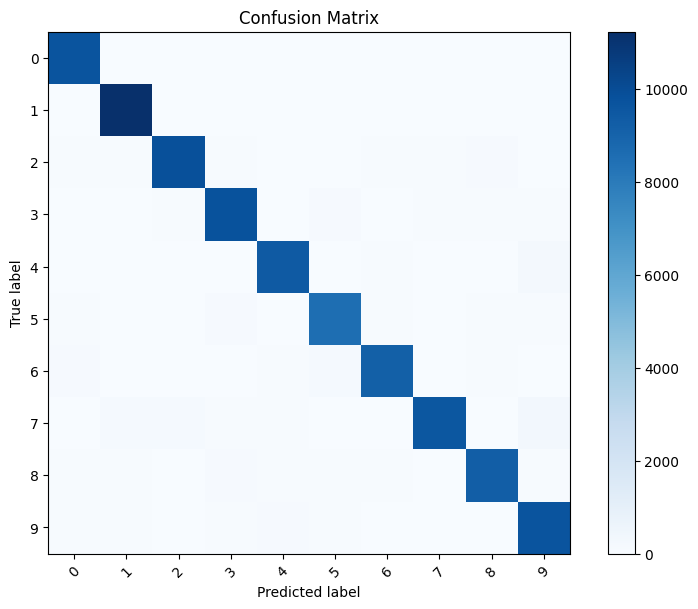

In [10]:

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, [str(i) for i in range(10)], rotation=45)
plt.yticks(tick_marks, [str(i) for i in range(10)])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Print Classification Report with Precision, Recall and F1-score

In [11]:
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      9800
           1       0.97      0.99      0.98     11350
           2       0.97      0.95      0.96     10320
           3       0.96      0.97      0.96     10100
           4       0.96      0.96      0.96      9820
           5       0.95      0.96      0.95      8920
           6       0.97      0.95      0.96      9580
           7       0.98      0.93      0.95     10280
           8       0.96      0.95      0.95      9740
           9       0.93      0.96      0.94     10090

    accuracy                           0.96    100000
   macro avg       0.96      0.96      0.96    100000
weighted avg       0.96      0.96      0.96    100000



Print accuracy per class and general accuracy

In [12]:

print("\nAccuracy Per Class:")
for i, acc in enumerate(class_accuracy):
    print(f"Class {i}: {acc:.4f}")

print(f"\nGeneral Accuracy: {general_accuracy:.4f}")
    


Accuracy Per Class:
Class 0: 0.9885
Class 1: 0.9896
Class 2: 0.9545
Class 3: 0.9667
Class 4: 0.9591
Class 5: 0.9564
Class 6: 0.9530
Class 7: 0.9285
Class 8: 0.9474
Class 9: 0.9586

General Accuracy: 0.9606
